#Graph classification on the MUTAG dataset:
In this notebook we perform graph classification on the MUTAG dataset using a Graph Neural Network (GNN) in PyTorch Geometric.

**Outcome:** We aim to build a model that can classify graphs based on their structural properties and node features, specifically identifying whether a given graph (representing a chemical compound) is mutagenic or not.

**Dataset:** The MUTAG dataset is a collection of graphs where each graph represents a chemical compound. Each graph is labeled as either mutagenic (causing genetic mutations) or non-mutagenic. The task is to classify these graphs correctly.

In [26]:
!pip install torch-geometric --quiet

In [22]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.nn import GCNConv, global_mean_pool

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

### Load Dataset

In [23]:
# Load the dataset
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

# Split the dataset into train and test sets
train_dataset = dataset[:150]
test_dataset = dataset[150:]

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Let's look at the first graph of the dataset.

In [24]:
dataset[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

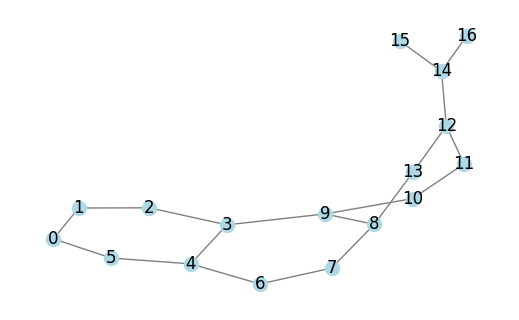

In [56]:
# Function to plot a single graph
def plot_graph(data, figsize=(5, 3)):
    plt.figure(figsize=figsize)
    G = to_networkx(data, to_undirected=True)
    nx.draw(G, with_labels=True, node_color='lightblue', node_size=100, edge_color='gray')
    plt.show()

# Plot the first three graphs in the dataset
plot_graph(dataset[0])

Now, let's see what does a sample batch with size 4 look like.

In [53]:
sample_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
batch = next(iter(sample_loader))
batch

DataBatch(edge_index=[2, 172], x=[76, 7], edge_attr=[172, 4], y=[4], batch=[76], ptr=[5])

In [54]:
batch.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3])

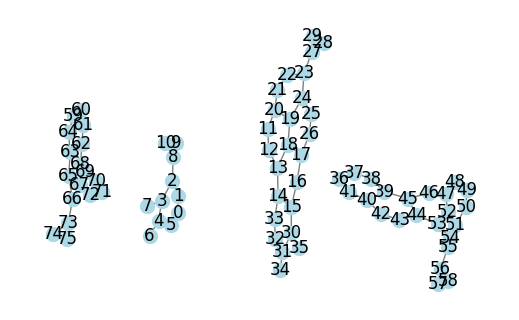

In [58]:
plot_graph(batch)

### Model Definition

In [60]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        # Global mean pooling
        x = global_mean_pool(x, batch)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In PyTorch Geometric, the function **global_mean_pool(x, batch)** is used to perform global mean pooling on graph-level representations. This operation aggregates node features into a single graph-level feature vector by taking the mean of the node features for each graph in a batch.

Explanation



*   **x:** This is the node feature matrix of shape [num_nodes, num_features]. Each row represents the features of a node.
*   **batch:** This is a vector of shape [num_nodes] where each entry indicates the graph to which the corresponding node belongs. It essentially acts as an index mapping each node to a specific graph in the batch.






### Training

In [61]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

for epoch in range(1, 501):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 50 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 050, Loss: 0.4527, Train Acc: 0.7733, Test Acc: 0.6842
Epoch: 100, Loss: 0.4594, Train Acc: 0.7933, Test Acc: 0.6842
Epoch: 150, Loss: 0.4357, Train Acc: 0.8333, Test Acc: 0.6842
Epoch: 200, Loss: 0.4206, Train Acc: 0.8200, Test Acc: 0.6842
Epoch: 250, Loss: 0.4267, Train Acc: 0.8333, Test Acc: 0.7105
Epoch: 300, Loss: 0.4212, Train Acc: 0.8333, Test Acc: 0.7368
Epoch: 350, Loss: 0.4106, Train Acc: 0.8400, Test Acc: 0.7368
Epoch: 400, Loss: 0.4137, Train Acc: 0.8333, Test Acc: 0.7632
Epoch: 450, Loss: 0.4107, Train Acc: 0.8400, Test Acc: 0.7368
Epoch: 500, Loss: 0.4070, Train Acc: 0.8533, Test Acc: 0.7368


### Evaluation

In [62]:
test_acc = test(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.7368


## Graph Attention Networks

### Model Definition
Now let's use GAT instead of simple GCN and see how it can improve the accuracy.

In [74]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool


class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, num_heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 64, heads=num_heads, concat=True)
        self.conv2 = GATConv(64 * num_heads, 64, heads=num_heads, concat=True)
        self.fc = torch.nn.Linear(64 * num_heads, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

### Training

In [75]:
num_heads = 2  # Number of attention heads
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(dataset.num_features, dataset.num_classes, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    return total_loss / len(train_loader)

# Test function
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Train and test the model
for epoch in range(1, 501):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 050, Loss: 0.4680, Train Acc: 0.8067, Test Acc: 0.7368
Epoch: 100, Loss: 0.4637, Train Acc: 0.7800, Test Acc: 0.7105
Epoch: 150, Loss: 0.4172, Train Acc: 0.8467, Test Acc: 0.7895
Epoch: 200, Loss: 0.4075, Train Acc: 0.8400, Test Acc: 0.7895
Epoch: 250, Loss: 0.3936, Train Acc: 0.8533, Test Acc: 0.7895
Epoch: 300, Loss: 0.4296, Train Acc: 0.8333, Test Acc: 0.7895
Epoch: 350, Loss: 0.4056, Train Acc: 0.8533, Test Acc: 0.7895
Epoch: 400, Loss: 0.3952, Train Acc: 0.8467, Test Acc: 0.7895
Epoch: 450, Loss: 0.4018, Train Acc: 0.8533, Test Acc: 0.7895
Epoch: 500, Loss: 0.3941, Train Acc: 0.8533, Test Acc: 0.7895


### Evaluation

In [76]:
test_acc = test(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7895


We see that the accuracy has improved using GAT compared to the previous model architecture. This improvement can be attributed to the enhanced capability of GAT to capture more complex graph structures and dependencies through its attention mechanism. By allowing nodes to selectively attend to their neighbors, GAT can effectively aggregate information from neighboring nodes while considering their importance, leading to more informative node representations.